Previous year there was a [good Computer Vision practice lesson](https://www.youtube.com/watch?v=XSPYe4-y4HE) (RUS), its [notebooks](https://drive.google.com/drive/folders/1ZpS8oyI__3QvjoIwVZwur4I5e4qIExPS?usp=sharing).

This year we will master inference and training of the SSD neural network discussed on the lecture.

:This notebook is based on [NVIDIA deep learning examples](https://github.com/NVIDIA/DeepLearningExamples ). 

**[Cinematic NVIDIA keynotes](https://www.youtube.com/watch?v=CKnipnFsuFo&

---

list=PLZHnYvH1qtOYOfzAj7JZFwqtabM5XPku1) on Deep Learning 2020.**



# SSD

*Author: NVIDIA*

**Single Shot MultiBox Detector model for object detection**

_ | _
- | -
![alt](https://pytorch.org/assets/images/ssd_diagram.png) | ![alt](https://pytorch.org/assets/images/ssd.png)

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as tfs
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from torchvision import models
from IPython.display import clear_output

import pandas as pd

from __future__ import print_function, division
import os

from skimage import io, transform

from tqdm.notebook import tqdm
from tqdm.autonotebook import trange
import pickle
from sklearn.model_selection import train_test_split
from PIL import Image
from pathlib import Path
from multiprocessing.pool import ThreadPool
import time

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu') 
device


device(type='cuda', index=0)

In [8]:
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)


Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [9]:
ssd_model.to(device)
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

will load an SSD model pretrained on COCO dataset from Torch Hub.

Setting precision='fp16' will load a checkpoint trained with [mixed precision](https://arxiv.org/abs/1710.03740) into architecture enabling execution on [Tensor Cores](https://developer.nvidia.com/tensor-cores).
Handling mixed precision data requires [Apex](https://github.com/NVIDIA/apex) library.



### Model Description

This SSD300 model is based on the
[SSD: Single Shot MultiBox Detector](https://arxiv.org/abs/1512.02325) paper, which
describes SSD as “a method for detecting objects in images using a single deep neural network".
The input size is fixed to 300x300.

The main difference between this model and the one described in the paper is in the backbone.
Specifically, the VGG model is obsolete and is replaced by the ResNet-50 model.

From the
[Speed/accuracy trade-offs for modern convolutional object detectors](https://arxiv.org/abs/1611.10012)
paper, the following enhancements were made to the backbone:
*   The conv5_x, avgpool, fc and softmax layers were removed from the original classification model.
*   All strides in conv4_x are set to 1x1.

The backbone is followed by 5 additional convolutional layers.
In addition to the convolutional layers, we attached 6 detection heads:
*   The first detection head is attached to the last conv4_x layer.
*   The other five detection heads are attached to the corresponding 5 additional layers.

Detector heads are similar to the ones referenced in the paper, however,
they are enhanced by additional BatchNorm layers after each convolution.

### Example

In the example below we will use the pretrained SSD model loaded from Torch Hub to detect objects in sample images and visualize the result.

To run the example you need some extra python packages installed.
These are needed for preprocessing images and visualization.

File [utils.py](https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/Detection/SSD/src/utils.py) that containes Encoder and dboxes_300 code.

In [3]:
# List of available models in PyTorch Hub from Nvidia/DeepLearningExamples
torch.hub.list('NVIDIA/DeepLearningExamples:torchhub')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


['nvidia_convnets_processing_utils',
 'nvidia_efficientnet',
 'nvidia_efficientnet_b0',
 'nvidia_efficientnet_b4',
 'nvidia_efficientnet_widese_b0',
 'nvidia_efficientnet_widese_b4',
 'nvidia_gpunet',
 'nvidia_resneXt',
 'nvidia_resnet50',
 'nvidia_resnext101_32x4d',
 'nvidia_se_resnext101_32x4d',
 'nvidia_ssd',
 'nvidia_ssd_processing_utils',
 'nvidia_tacotron2',
 'nvidia_tft',
 'nvidia_tft_data_utils',
 'nvidia_tts_utils',
 'nvidia_waveglow']

In [17]:
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', "nvidia_ssd_processing_utils")

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [18]:
!cat /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/hubconf.py


import os
import sys

from PyTorch.Detection.SSD.ssd import nvidia_ssd, nvidia_ssd_processing_utils
sys.path.append(os.path.join(sys.path[0], 'PyTorch/Detection/SSD'))

from PyTorch.Classification.ConvNets.image_classification.models import resnet50 as nvidia_resnet50
from PyTorch.Classification.ConvNets.image_classification.models import resnext101_32x4d as nvidia_resnext101_32x4d
from PyTorch.Classification.ConvNets.image_classification.models import se_resnext101_32x4d as nvidia_se_resnext101_32x4d
from PyTorch.Classification.ConvNets.image_classification.models import efficientnet_b0 as nvidia_efficientnet_b0
from PyTorch.Classification.ConvNets.image_classification.models import efficientnet_b4 as nvidia_efficientnet_b4
from PyTorch.Classification.ConvNets.image_classification.models import efficientnet_widese_b0 as nvidia_efficientnet_widese_b0
from PyTorch.Classification.ConvNets.image_classification.models import efficientnet_widese_b4 as nvidia_efficientnet_widese_b4
from PyTo

In [19]:
uris = [
    'http://images.cocodataset.org/val2017/000000397133.jpg',
    'http://images.cocodataset.org/val2017/000000037777.jpg',
    'http://images.cocodataset.org/val2017/000000252219.jpg',
    'https://i.ibb.co/ZVqGsbJ/nvidia-image-300.jpg'
]

inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs, precision == 'fp16')

(4, 3, 300, 300)


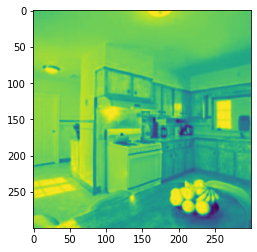

In [38]:
proba = tensor.cpu().detach().numpy()
print(proba.shape)
#plt.imshow(proba[0,0,:,:])
plt.imshow(proba[1,0,:,:])
#plt.imshow(proba[2,0,:,:])
#plt.imshow(proba[3,0,:,:])

In [41]:
with torch.no_grad():
    detections_batch = ssd_model(tensor)

In [42]:
print(len(detections_batch))
print(len(detections_batch[0]), detections_batch[0].shape)
print(len(detections_batch[1]), detections_batch[1].shape)

2
4 torch.Size([4, 4, 8732])
4 torch.Size([4, 81, 8732])


In [43]:
results_per_input = utils.decode_results(detections_batch)
print(len(results_per_input), len(results_per_input[0]), 
      results_per_input[1][0].shape, results_per_input[1][1].shape, results_per_input[1][2].shape)

4 3 (20, 4) (20,) (20,)


In [56]:
# 0.2 - probabiltiy of 
# threshold_probabitiry
threshold_probabitiry = 0.22
best_results_per_input = [utils.pick_best(results, threshold_probabitiry) for results in results_per_input]
print(len(best_results_per_input), len(best_results_per_input[0]), 
      best_results_per_input[1][0].shape, best_results_per_input[1][1].shape, best_results_per_input[1][2].shape)

4 3 (1, 4) (1,) (1,)


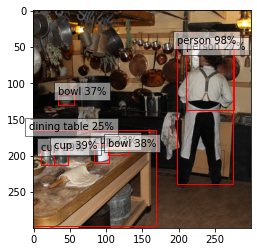

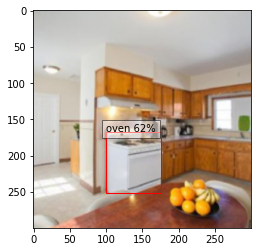

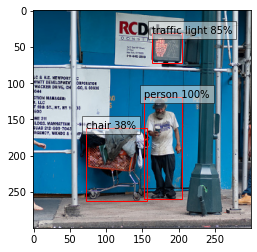

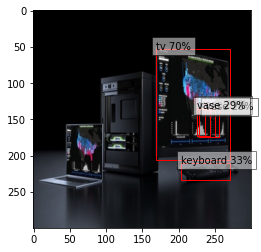

In [57]:
classes_to_labels = utils.get_coco_object_dictionary()
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # Show original, denormalized image...
    image = inputs[image_idx] / 2 + 0.5
    ax.imshow(image)
    # ...with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val * 300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, "{} {:.0f}%".format(classes_to_labels[classes[idx] - 1], confidences[idx]*100), bbox=dict(facecolor='white', alpha=0.5))
plt.show()

### Details
For detailed information on model input and output,
training recipies, inference and performance visit:
[github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Detection/SSD)
and/or [NGC](https://ngc.nvidia.com/catalog/model-scripts/nvidia:ssd_for_pytorch)

### Useful links

 - [SSD: Single Shot MultiBox Detector](https://arxiv.org/abs/1512.02325) paper
 - [Speed/accuracy trade-offs for modern convolutional object detectors](https://arxiv.org/abs/1611.10012) paper
 - [SSD on NGC](https://ngc.nvidia.com/catalog/model-scripts/nvidia:ssd_for_pytorch)
 - [SSD on github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/Detection/SSD)
 - [TensorRT tutorial](https://nvidia.github.io/Torch-TensorRT/tutorials/use_from_pytorch.html#use-from-pytorch)